In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
!pip install konlpy
!pip install kss

In [ ]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

In [ ]:
cd Mecab-ko-for-Google-Colab

In [ ]:
!bash install_mecab-ko_on_colab190912.sh

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


train_shape : (25873, 3200, 1) / (25873, 2)
test_shape : (2875, 3200, 1) / (2875, 2)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 3200, 16)          160       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 3200, 16)          400       
_________________________________________________________________
bidirectional_2 (Bidirection (None, 16)                400       
_________________________________________________________________
dense (Dense)                (None, 2)                 34        
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 994
Trainable params: 994
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1024
23/23 [===================

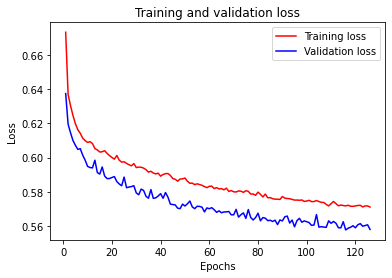

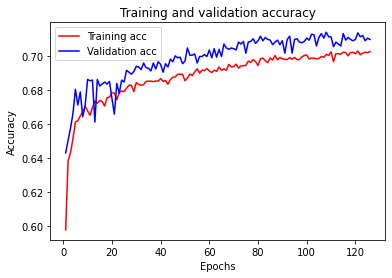

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.74      0.61      0.67      1428
           1       0.68      0.79      0.73      1447

    accuracy                           0.70      2875
   macro avg       0.71      0.70      0.70      2875
weighted avg       0.71      0.70      0.70      2875

Predicted    0     1
True                
0          877   551
1          301  1146


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Activation, Bidirectional
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder; LE = LabelEncoder()
from sklearn.metrics import classification_report
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Mecab

def birnn():
    model = Sequential()
    model.add(Bidirectional(SimpleRNN(2 ** 3, return_sequences=True), input_shape=(max_len*100, 1)))
    model.add(Bidirectional(SimpleRNN(2 ** 3, return_sequences=True)))
    model.add(Bidirectional(SimpleRNN(2 ** 3, return_sequences=False)))

    model.add(Dense(2))
    model.add(Activation('softmax'))
    adam = optimizers.Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()
    early_stopping = EarlyStopping(patience=10)
    history = model.fit(x_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])

    return model, history

if __name__ == "__main__":
    max_len = 32
    epochs = 2 ** 10
    batch_size = 2 ** 10

    mecab = Mecab()

    model = Word2Vec.load('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/word2vec')

    depression_dataset_path = r'/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_dataset_맞춤법O.csv'

    depression_dataset = pd.read_csv(depression_dataset_path, encoding='cp949')

    df = []

    for i in range(len(depression_dataset)):
        df.append(mecab.morphs(depression_dataset.iloc[i,0]))

    for i in range(len(df)):
        for j in range(len(df[i])):
            try:
                df[i][j] = model.wv.get_vector(df[i][j]).tolist()
            except:
                df[i][j] = False

    for i in range(len(df)):
        while False in df[i]:
            df[i].remove(False)

    for i in range(len(df)):
        if len(df[i]) >= max_len:
            df[i] = df[i][-32:]
        else:
            for j in range(max_len-len(df[i])):
                df[i].insert(0,0)

    for i in range(len(df)):
        for j in range(len(df[i])):
            if df[i][j] == 0:
                df[i][j] = [0]*100

    depression_dataset['label_1'] = LE.fit_transform(depression_dataset['label_1'])

    x_train, x_test, y_train, y_test = train_test_split(df, depression_dataset['label_1'], test_size=0.1, random_state=42)

    x_train = np.array(x_train).reshape((len(x_train), max_len*100, 1))
    x_test = np.array(x_test).reshape((len(x_test), max_len*100, 1))

    y_true = copy.deepcopy(y_test)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    print('train_shape : {} / {}'.format(x_train.shape, y_train.shape))
    print('test_shape : {} / {}'.format(x_test.shape, y_test.shape))

    model, history = birnn()

    scores = model.evaluate(x_test, y_test)
    print(scores)
    print("정확도: %.2f%%" % (scores[1] * 100))

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    y_true = list(y_true)
    y_pred = model.predict_classes(x_test)
    y_pred = list(y_pred)

    print(classification_report(y_true, y_pred))
    print(pd.crosstab(pd.Series(y_true), pd.Series(y_pred), rownames=['True'], colnames=['Predicted']))